# Wrangle OpenStreetMap Data

> [1. Introduction](#1.-Introduction)

> [2. Modules Used](#2.-Modules-Used)

> [3. Knowing the XML OSM Dataset](#3.-Knowing-the-XML-OSM-Dataset)

> [4. Problems Encountered in the Map](#4.-Problems-Encountered-in-the-Map)

> [5. Importing XML OSM Dataset to MongoDB](#5.-Importing-XML-OSM-Dataset-to-MongoDB)

> [6. Overview of the Data](#6.-Overview-of-the-Data)

> [7. Other Ideas About the Datasets](#7.-Other-Ideas-About-the-Datasets)


## 1. Introduction

In this project I used data munging techniques over a region of Brazil that includes the Goiás state [relation](http://www.openstreetmap.org/relation/334443). The state of Goiás is located in the Center-West region of the country and has the Goiânia city (where I live) as its capital. To know more about the Goiás state, go to [Wikipedia](https://en.wikipedia.org/wiki/Goi%C3%A1s).

The image below highlights on the map the region that XML OSM dataset was extracted from OpenStreetMap.

> I used Overpass API to download the dataset of custom square area. Here is link used for download: http://overpass-api.de/api/map?bbox=-53.394,-19.518,-45.923,-12.254

> **Attention!** The dataset is large, approximately 1.5 GB. 

![Huge Region](./images/exported_huge_region.png "Huge Region")

## 2. Modules Used

I've created the `helpers` module to organizate code related to XML, plot and IO manipulation. It is located in the `code` folder of this project.

In [1]:
import code.helpers as hlp

The third-party modules used are listed below.

In [2]:
from pymongo import MongoClient
import re

## 3. Knowing the XML OSM Dataset

I used two XML OSM dataset: `exported_huge_region.osm` and `exported_sample_region.osm`. Both files are in `data` folder of this project. The `exported_sample_region.osm` file contains data about downtown of Goiânia city and is a subset of `exported_huge_region.osm`.

> I used Overpass API to download the `exported_sample_region.osm` dataset. Here is link used for download: http://overpass-api.de/api/map?bbox=-49.298,-16.727,-49.219,-16.655

The reason to use `exported_sample_region.osm` file is to start out by looking at a smaller sample of selected region. That helps to create and validate faster the auditing codes since the `exported_sample_region.osm` file contains 7.68 MB while the `exported_huge_region.osm` file contains 1.48 GB.

> During my analisys I created others XML OSM datasets as outcome of cleaning processing (before I insert them into MongoDB). These datasets also are huge as `exported_huge_region.osm`.

In [3]:
OSM_DIR = "./data/"
HUGE_OSM_FILE_PATH = OSM_DIR + "exported_huge_region.osm"
SAMPLE_OSM_FILE_PATH = OSM_DIR + "exported_sample_region.osm"

print("Huge XML OSM Dataset size: {}".format(hlp.file_size(HUGE_OSM_FILE_PATH)))
print("Sample XML OSM Dataset size: {}".format(hlp.file_size(SAMPLE_OSM_FILE_PATH)))

Huge XML OSM Dataset size: 1.48 GB
Sample XML OSM Dataset size: 7.68 MB


For the data reported in this project I used the huge XML OSM dataset (`exported_huge_region.osm`).

In [4]:
SELECTED_OSM_FILE_PATH = HUGE_OSM_FILE_PATH
SELECTED_OSM_FILE_PATH

'./data/exported_huge_region.osm'

The code below shows how many XML elements there are in the dataset.

In [5]:
# This function is invoked for every element in XML.
# It counts how many times a element appear in XML.
# The 'accumulator' param is the 'accumulator' returned in previously.
# The 'accumulator' param is initialized with a 'dict()' by 
# 'hlp.proccess_xml' function invocation.
def element_count(accumulator, element, event):
    if event == "start":
        accumulator[element.tag] = accumulator.get(element.tag, 0) + 1
    return accumulator

def apply_element_count(in_osm_file):
    # Invokes 'count_elements' function for every element in XML.
    dict_key_count = hlp.proccess_xml(in_osm_file, 
                                 element_count, 
                                 accumulator=dict())
    return dict_key_count

def show_element_count(dict_key_count):
    # Skip one line.
    print("")
    # Sort by value and print out. 
    hlp.print_dict(hlp.sort_dict(dict_key_count, 
                                 sort_function=(lambda (k,v): (v, k)),
                                 reverse=True))
    # Skip one line.
    print("")

In [6]:
%time dict_key_count = apply_element_count(SELECTED_OSM_FILE_PATH)
show_element_count(dict_key_count)

CPU times: user 1min 18s, sys: 2.96 s, total: 1min 21s
Wall time: 1min 27s

{
    "nd": 8004800, 
    "node": 7253916, 
    "tag": 914669, 
    "way": 361142, 
    "member": 62120, 
    "relation": 7617, 
    "remark": 1, 
    "osm": 1, 
    "note": 1, 
    "meta": 1, 
    "bounds": 1
}



## 4. Problems Encountered in the Map

Now I will show the problems and solution I found in my analysis of the 914,669 `tag` elements. A `tag` element is formed by two attributes named `k` and `v` and do not have subelements. The `k` attribute represents the key and the `v` attribute represents the value. Thus, a `tag` element represents a pair of `key=value`. More about `tag` element can be seen in [Tags](http://wiki.openstreetmap.org/wiki/Tags) documentation. I found problems in both attributes. Let's start out by `k` attribute.

### 4.1 'K' Attribute

To get an idea of the data we are working on I wrote the code below that list 5 most used `k` attributes, the number of times each of them appeared, and a sample (maximum 5) of content of the `v` attribute.

In [7]:
# This function is invoked for every element in XML.
# It counts how many times a 'k' attribute appear in 'tag' elemet and 
# shows the first 5 respective 'v' attribute.
#
# "<'k' attribute>": {
#    "count": ..., 
#    "sample": [ <first 5 'v' attribute> ]
#  }
#
# The 'accumulator' param is the 'accumulator' returned in previously.
# The 'accumulator' param is initialized with a 'dict()' by 
# 'hlp.proccess_xml' function invocation.
def group_tag_by_key(accumulator, element, event):
    if event == "start":
        if element.tag == "tag":
            value = accumulator.get(element.attrib['k'], {"count": 0, "sample": set()})
            value["count"] += 1
            if(len(value["sample"]) < 5):
                value["sample"].add(element.attrib['v'])
            accumulator[element.attrib['k']] = value
    return accumulator

# Applies 'group_tag_by_key' function in "exported_huge_region.osm"
def apply_group_tag_by_key(in_osm_file):
    # Invokes 'group_tag_by_key' function for every element in XML.
    dict_key_groups = hlp.proccess_xml(in_osm_file, 
                                        group_tag_by_key, 
                                        accumulator=dict())
    return dict_key_groups

# Shows key tag groups with size greater than 1000. 
# {
#    "<'k' attribute>": {
#       "count": ..., 
#       "sample": [ <first 5 'v' attribute> ]
#     },
#     ...
# }
def show_group_tag_by_key(dict_key_groups):
    # Filters 'key_groups' dict with 'count' field greater than 50,000.
    filtered_key_groups = hlp.filter_dict(dict_key_groups, 
                                          (lambda (k,v): v["count"] > 50000))
    # Skip one line.
    print("")
    print("Number of groups: {}".format(len(dict_key_groups)))
    print("Showing only first {} groups...".format(len(filtered_key_groups)))
    print("")
    # Sort by 'count' field and print out. 
    hlp.print_dict(hlp.sort_dict(filtered_key_groups, 
                                 sort_function=(lambda (k,v): (v["count"], k)), 
                                 reverse=True))
    # Skip one line.
    print("")

In [8]:
%time dict_key_groups = apply_group_tag_by_key(SELECTED_OSM_FILE_PATH)
show_group_tag_by_key(dict_key_groups)

CPU times: user 1min 13s, sys: 2.65 s, total: 1min 16s
Wall time: 1min 19s

Number of groups: 908
Showing only first 5 groups...

{
    "highway": {
        "count": 241061, 
        "sample": [
            "crossing", 
            "bus_stop", 
            "speed_camera", 
            "traffic_signals", 
            "turning_circle"
        ]
    }, 
    "name": {
        "count": 149609, 
        "sample": [
            "612 Norte", 
            "Ponto de \u00d4nibus do CEAN", 
            "604 Norte - Carmen Salles", 
            "Bras\u00edlia", 
            "Goi\u00e2nia"
        ]
    }, 
    "source": {
        "count": 82175, 
        "sample": [
            "IBGE;survey", 
            "geominas,wikipedia", 
            "Bing", 
            "IBGE", 
            "geominas"
        ]
    }, 
    "surface": {
        "count": 58138, 
        "sample": [
            "ground", 
            "dirt", 
            "unpaved", 
            "asphalt", 
            "paved"
        ]
    }, 


Then, I used the site [Taginfo](https://taginfo.openstreetmap.org/keys) to discover the meanings of some `k` attributes and the sites listed below to know some syntactic conventions for tags.
- [Map Features](http://wiki.openstreetmap.org/wiki/Map_Features)
- [Any Tags You Like](http://wiki.openstreetmap.org/wiki/Any_tags_you_like)
- [How to Invent Tags](http://wiki.openstreetmap.org/wiki/User:Joto/How_to_invent_tags)

#### 4.1.1 Semantic Problems

Looking around, you can see that some `k` attributes apparently represent the same thing. For example, the `postal_code` `k` attribute, semantically, has the same meaning as the `addr:postcode`.

- `"postal_code": {"count": 4593, "sample": ["74968970", "75690-971", ...]}`
- `"addr:postcode": {"count": 1489, "sample": ["75903-290", "70645-135", ...]}`

It does not become a structural problem but do not follow conventions or do not reuse `k` attributes names leads to interpretation and integration problems.

To find these semantic problems is very complicated because there are many attributes. In the huge XML OSM dataset there is 908 distinct `k` attributes. It is insane to treat them manually. And the resolution of them is very complicated because the same data can have different semantics in distinct situations. There is no 100% certainty for all cases.

I created the code below to help me to find possibly more cases of semantic problems. I listed in a new field (`similar_key`) the `k` attributes that have 80% or more of similarity with a given `k` attribute returned in previous outcome.

In [9]:
# This function creates a field named 'similar_key' in the dict
# returned by previouly XML processing with
# similar "<'k' attribute>" text.
#
# "<'k' attribute>": {
#    "count": ..., 
#    "sample": [ <first 5 'v' attribute> ]
#    "similar_key": [
#        {
#            "<'k' attribute>": {
#                "count": ..., 
#                "sample": [ <first 5 'v' attribute> ],
#            "<'k' attribute>": {
#                "count": ..., 
#                "sample": [ <first 5 'v' attribute> ],
#            ...
#            ...
#                
#        }
#     ]
#  }
#
def group_tag_by_key_similarity(dict_, ratio):
    group_dict = dict()
    list_k_attr = dict_.keys()
    # Compares every key with all keys
    for idx_1, k_attr_1 in enumerate(list_k_attr):
        for k_attr_2 in list_k_attr[(idx_1 + 1):]:
            k_attr_1_parts = k_attr_1.lower().split(":")
            k_attr_2_parts = k_attr_2.lower().split(":")
            acc_ratio = 0
            # Compares every key level with all levels
            for idx_p1, part_1 in enumerate(k_attr_1_parts):
                for idx_p2, part_2 in enumerate(k_attr_2_parts):
                    # Calculates the similarity
                    sim = hlp.similarity(part_1, part_2)
                    # Do not accumulates ratio with 100% matched in begin of keys
                    # E.g: 
                    #      key1="addr:name" key2="addr:street"
                    #      addr             addr               (ignored)
                    #      addr             street             (0.2)
                    #      name             addr               (0.25)
                    #      name             street             (0.2)
                    # acc_ratio = 0.2+0.25+0.2 = 0.65  
                    if (sim == 1.0) and (idx_p1 == idx_p2):
                        continue
                    if sim >= ratio:
                        acc_ratio += sim
            # Returns only keys with acc_ratio equal or greater than desired ratio.
            if acc_ratio >= ratio:                        
                value = group_dict.get(k_attr_1, dict())
                for key in dict_[k_attr_1]:
                    value[key] = dict_[k_attr_1][key]
                value["similar_key"] = value.get("similar_key", list())
                value["similar_key"].append(dict([(k_attr_2, dict_[k_attr_2])]))
                group_dict[k_attr_1] = value        
        
    return group_dict 

# Shows similarity groups with size greater than 50,000. 
def show_group_tag_by_key_similarity(similar_key_groups):
    # Filters 'similar_key_groups' dict with 'count' field greater than 50,000.
    filtered_similar_key_groups = hlp.filter_dict(similar_key_groups, 
                                                  (lambda (k,v): v["count"] > 50000))
    # Skip one line.
    print("")
    print("Number of groups: {}".format(len(similar_key_groups)))
    print("Showing only first {} groups...".format(len(filtered_similar_key_groups)))
    print("")
    # Sort by 'count' field and print out. 
    hlp.print_dict(hlp.sort_dict(filtered_similar_key_groups, 
                                 sort_function=(lambda (k,v): (v["count"], k)),
                                 reverse=True))
    # Skip one line.
    print("")

In [10]:
# Creates a field named 'similar_key' in the dict returned by 
# previouly XML processing with similar "<'k' attribute>" text in 0.8 ratio.
%time dict_similar_key_groups = group_tag_by_key_similarity(dict_key_groups, ratio=0.8) 
show_group_tag_by_key_similarity(dict_similar_key_groups)

CPU times: user 27.9 s, sys: 263 ms, total: 28.2 s
Wall time: 29.2 s

Number of groups: 432
Showing only first 3 groups...

{
    "highway": {
        "count": 241061, 
        "sample": [
            "crossing", 
            "bus_stop", 
            "speed_camera", 
            "traffic_signals", 
            "turning_circle"
        ], 
        "similar_key": [
            {
                "source:highway": {
                    "count": 137, 
                    "sample": [
                        "schema_br2013"
                    ]
                }
            }, 
            {
                "highway_1": {
                    "count": 3, 
                    "sample": [
                        "grade4", 
                        "roundabout"
                    ]
                }
            }
        ]
    }, 
    "name": {
        "count": 149609, 
        "sample": [
            "612 Norte", 
            "Ponto de \u00d4nibus do CEAN", 
            "604 Norte - Carmen Sall

The `sample` fields help me to decide what `k` attributes I will merge. If the `sample` fields of the related `k` attributes in the `similiar_key` field appear to contain the same content as the `sample` field of the parent `k` attribute then they will be merged in the parent `k` attribute. 

Analyzing the groups with `count` field greater than 1,000 (26 groups) I decided to merge the following tags by considering them semantically equal:

- `"highway": "highway_1"`
- `"name": "name_1"`
- `"surface": "surface_1"`
- `"natural": ["natural_1", "natural_2"]`
- `"landuse": "landuse_2"`
- `"leisure": ["leisure_1", "leisure_2"]`
- `"addr:city": "City"`
- `"addr:suburb": "addr:suburb_1"`
- `"addr:postcode": "postal_code"`
- `"barrier": "barrier_1"`
- `"layer": "layer_1"`
- `"building:levels": "building:levels_1"`
- `"sport": ["sport_3", "sport_1", "sport_2"]`
- `"contact:phone": "phone"`

Below is the implementation of the code that performs the merge tags. Basically what the code does is rename the `k` attribute according to the mapping in `mapping_to_merge` function and save the resulting OSM XML into a new file named `merged_huge_region.osm`.

In [11]:
def mapping_to_merge():
    return {
        "highway_1": "highway",
        "name_1": "name",
        "surface_1": "surface",
        "natural_1": "natural",
        "natural_2": "natural",
        "landuse_2": "landuse",
        "leisure_1": "leisure",
        "leisure_2": "leisure",
        "City": "addr:city",
        "addr:suburb_1": "addr:suburb",
        "postal_code": "addr:postcode",
        "barrier_1": "barrier",
        "layer_1": "layer",
        "building:levels_1": "building:levels",
        "sport_3": "sport",
        "sport_1": "sport",
        "sport_2": "sport",
        "phone": "contact:phone"
    }

# Case 'k' attribute is in mapping_to_merge rename it 
# and write the tag in "merged_huge_region.osm"
def rename_k_attr(writter, element, event):    
    if event == "start":
        mapping = mapping_to_merge()
        if element.tag == "tag":
            k_attr = element.attrib['k']
            if k_attr in mapping:
                element.attrib['k'] = mapping[k_attr]
        writter.write(hlp.start_element_to_string(element))
    elif event == "end":
        writter.write(hlp.end_element_to_string(element))    
    return writter

# Applies 'rename_k_attr' function in exported_huge_region.osm
# and write the outcome in "merged_huge_region.osm"
def merge_tags_and_persist(in_osm_file, out_osm_file):
    hlp.modify_xml(in_osm_file, rename_k_attr, out_osm_file)

In [12]:
MERGED_OSM_FILE_PATH = OSM_DIR + "merged_huge_region.osm"
%time merge_tags_and_persist(SELECTED_OSM_FILE_PATH, MERGED_OSM_FILE_PATH)

CPU times: user 10min 27s, sys: 56.8 s, total: 11min 24s
Wall time: 11min 56s


From now on the resulting OSM XML file is the default.

In [13]:
SELECTED_OSM_FILE_PATH = MERGED_OSM_FILE_PATH
SELECTED_OSM_FILE_PATH

'./data/merged_huge_region.osm'

Just as I did previously, I used the code below to list the most used k attributes, the number of times each of them appeared, and a sample (maximum 5) of content of the v attribute. But now, after the merge, the number of distinct `k` attributes is 890. Previously, there were 908 of them.

In [14]:
%time dict_key_groups = apply_group_tag_by_key(SELECTED_OSM_FILE_PATH)
show_group_tag_by_key(dict_key_groups)

CPU times: user 1min 7s, sys: 1.83 s, total: 1min 9s
Wall time: 1min 12s

Number of groups: 890
Showing only first 5 groups...

{
    "highway": {
        "count": 241064, 
        "sample": [
            "crossing", 
            "bus_stop", 
            "speed_camera", 
            "traffic_signals", 
            "turning_circle"
        ]
    }, 
    "name": {
        "count": 149611, 
        "sample": [
            "612 Norte", 
            "Ponto de \u00d4nibus do CEAN", 
            "604 Norte - Carmen Salles", 
            "Bras\u00edlia", 
            "Goi\u00e2nia"
        ]
    }, 
    "source": {
        "count": 82175, 
        "sample": [
            "IBGE;survey", 
            "geominas,wikipedia", 
            "Bing", 
            "IBGE", 
            "geominas"
        ]
    }, 
    "surface": {
        "count": 58140, 
        "sample": [
            "ground", 
            "dirt", 
            "unpaved", 
            "asphalt", 
            "paved"
        ]
    }, 
  

One thing I noticed is that mostly semantic problems related to a tag occur in very small proportions. For example:

- `"highway_1": {"count": 3} against "highway": {"count": 241061}`
- `"name_1": {"count": 2} against "name": {"count": 149609}`
- `"City": {"count": 8} against "addr:city": {"count": 5961}`

The causes of this may be the lack of knowledge of the most popular tags ([Taginfo](https://taginfo.openstreetmap.org/keys)) or the need to use the same tag more than once to describe the same object.

#### 4.1.2 Syntatic Problems

In [Any Tags You Like](http://wiki.openstreetmap.org/wiki/Any_tags_you_like) and [How to Invent Tags](http://wiki.openstreetmap.org/wiki/User:Joto/How_to_invent_tags) there are some syntactic conventions for the `k` attribute. Based on this, I looked for syntactic problems in the dataset tags. 

The code below classifies the `k` attribute into 5 categories:

- **great\_key\_name**: all characters are in lowercase. The name begins with a letter. It can be followed by zero or more letters. The word separator is '`_`'. If the tag is multilevel, to represent the second level onwards, it is used the character '`:`' and the same rules described previouly.
- **good\_key\_name**: the same as great\_key\_name but uppercase characters and numbers are allowed. Starting with numbers are not allowed.
- **regular\_key\_name**: the same as good\_key\_name but starting with numbers are allowed. The word separator can be '`_`' or '`-`'.
- **bad\_key\_name**: the key name contains one or more special characters.
- **others**: unexpected names.

In [15]:
great_key_pattern = re.compile(
    """"
    ^                       # beginning of string
    (
        [a-z]               # starting with lowercase letter
        ([a-z]|_[a-z])*     # followed by zero or more lowercase letters. The word separator is '_'
        (
            :[a-z]          # case multilevel, starting with ':' followed by one lowercase letter
            ([a-z]|_[a-z])* # followed by zero or more lowercase letters. The word separator is '_'
        )*                  # can have zero or more multilevels
    )
    $                       # end of string
    """, re.VERBOSE)
good_key_pattern = re.compile(
    """
    ^                                    # beginning of string
    (
        [a-zA-Z]                         # starting with letter
        ([a-zA-Z0-9]|_[a-zA-Z0-9])*      # followed by zero or more numbers or letters. The word separator is '_'
        (
            :[a-zA-Z]                    # case multilevel, starting with ':' followed by one letter
            ([a-zA-Z0-9]|_[a-zA-Z0-9])*  # followed by zero or more numbers or letters. The word separator is '_'
        )*                               # can have zero or more multilevels
    )
    $                                    # end of string
    """, re.VERBOSE)
regular_key_pattern = re.compile(
    """
    ^                                       # beginning of string
    (
        [a-zA-Z0-9]                         # starting with letter or number
        ([a-zA-Z0-9]|[_-][a-zA-Z0-9])*      # followed by zero or more numbers or letters. The word separator is '_' or '-'
        (
            :[a-zA-Z0-9]                    # case multilevel, starting with ':' followed by one letter
            ([a-zA-Z0-9]|[_-][a-zA-Z0-9])*  # followed by zero or more numbers or letters. The word separator is '_' or '-'
        )*                                  # can have zero or more multilevels
    )
    $                                       # end of string
    """, re.VERBOSE)
bad_key_pattern = re.compile(
    """
    [=\+/&<>;\\\'"\?%#$@\,\. \t\r\n]        # contains one special character
    """, re.VERBOSE)

# Helper function to be used in classify_attr_keys.
# Creates um dict struct in accumulator like this:
#
# "<category>": {
#    "<'k' attribute>": {
#       "count": ..., 
#       "sample": [ <first 5 'v' attribute> ]
#     },
#     ...
# }
def classify(category, attr_key, sample, accumulator):
    value = accumulator.get(category, dict())
    key = value.get(attr_key, {"count": 0, "sample": set()})
    key["count"] += 1
    if(len(key["sample"]) < 5):
        key["sample"].add(sample)
    value[attr_key] = key
    accumulator[category] = value

def classify_attr_keys(accumulator, element, event):
    if event == "start":
        if element.tag == "tag":
            attr_key = element.attrib['k']
            attr_value = element.attrib['v']
            if great_key_pattern.search(attr_key):
                classify('great_key_name', attr_key, attr_value, accumulator)
            elif good_key_pattern.search(attr_key):
                classify('good_key_name', attr_key, attr_value, accumulator)
            elif regular_key_pattern.search(attr_key):
                classify('regular_key_name', attr_key, attr_value, accumulator)
            elif bad_key_pattern.search(attr_key):
                classify('bad_key_name', attr_key, attr_value, accumulator)
            else:
                classify('others', attr_key, attr_value, accumulator)
                
    return accumulator

# Applies 'classify_attr_keys' function in "merged_huge_region.osm".
def apply_classify_attr_keys(in_osm_file):
    # Invokes 'classify_attr_keys' function for every element in XML.
    dict_classified_keys = hlp.proccess_xml(in_osm_file, 
                                      classify_attr_keys, 
                                      accumulator=dict())
    return dict_classified_keys

# Shows 'bad_key_name' and 'others' categories
def show_bad_and_others_category(dict_classified_keys):
    # Filters 'dict_classified_keys' dict with 'bad_key_name' and 'others' categories
    filtered_dict_classified_keys = hlp.filter_dict(dict_classified_keys, 
                                                   (lambda (k,v): k in ["others", "bad_key_name"]))
    # Skip one line.
    print("")
    # Sort by value and print out. 
    hlp.print_dict(hlp.sort_dict(filtered_dict_classified_keys, 
                                 sort_function=(lambda (k,v): len(v))))
    # Skip one line.
    print("")

In [16]:
%time dict_classified_keys = apply_classify_attr_keys(SELECTED_OSM_FILE_PATH)
show_bad_and_others_category(dict_classified_keys)

CPU times: user 1min 4s, sys: 1.79 s, total: 1min 6s
Wall time: 1min 6s

{
    "others": {
        "endere\u00e7o": {
            "count": 1, 
            "sample": [
                "SGCV Sul Shopping Casa Park Lote 22"
            ]
        }
    }, 
    "bad_key_name": {
        "Distrito Postal": {
            "count": 18, 
            "sample": [
                "951", 
                "950", 
                "953", 
                "952", 
                "954"
            ]
        }, 
        "Pamonharia Cunha": {
            "count": 1, 
            "sample": [
                "yes"
            ]
        }
    }
}



After running the above code, we see that there is 1 unexpected key name, 2 bad key names. The unexpected key name `endere\u00e7o` contains one escaped unicode character (`ç`). The word that represents is `endereço` that in English is `address`. To correct the name of this key I will change it to `addr:full` ([Key:addr](http://wiki.openstreetmap.org/wiki/Key:addr)).

The 2 bad key names contain white space character between words: `Distrito Postal` and `Pamonharia Cunha`. We can change the name `Distrito Postal` to `addr:postcode` because they are semantically the same. Already `Pamonharia Cunha` is the name of an comercial establishment. It can be classified as `amenity=restaurant` ([Tag:amenity=restaurant](http://wiki.openstreetmap.org/wiki/Tag:amenity%3Drestaurant)). To correct the `Pamonharia Cunha=yes` tag I will change it to `amenity=restaurant` and create another tag: `name=Pamonharia Cunha`. The code below perform the required actions for that.

In [17]:
def corret_k_attr_names(writter, element, event):    
    if event == "start":
        if element.tag == "tag":
            if element.attrib['k'] == u"endere\u00e7o":
                element.attrib['k'] = "addr:full"
                writter.write(hlp.start_element_to_string(element))
            elif element.attrib['k'] == "Distrito Postal":
                element.attrib['k'] = "addr:postcode"
                writter.write(hlp.start_element_to_string(element))
            elif element.attrib['k'] == "Pamonharia Cunha":
                element.attrib['k'] = "amenity"
                element.attrib['v'] = "restaurant"
                writter.write(hlp.start_element_to_string(element))
                writter.write(hlp.end_element_to_string(element))
                element.attrib['k'] = "name"
                element.attrib['v'] = "Pamonharia Cunha"
                writter.write(hlp.start_element_to_string(element))
            else:
                writter.write(hlp.start_element_to_string(element))
        else:
            writter.write(hlp.start_element_to_string(element))
    elif event == "end":
        writter.write(hlp.end_element_to_string(element))    
    return writter

# Applies 'corret_k_attr_names' function in merged_huge_region.osm
# and write the outcome in "corrected_key_tag_huge_region.osm"
def corret_key_names_and_persist(in_osm_file, out_osm_file):
    hlp.modify_xml(in_osm_file, corret_k_attr_names, out_osm_file)

In [18]:
CORRECTED_KEY_TAG_OSM_FILE_PATH = OSM_DIR + "corrected_key_tag_huge_region.osm"
%time corret_key_names_and_persist(SELECTED_OSM_FILE_PATH, CORRECTED_KEY_TAG_OSM_FILE_PATH)

CPU times: user 9min 19s, sys: 53.4 s, total: 10min 12s
Wall time: 10min 27s


From now on the resulting OSM XML file is the default.

In [19]:
SELECTED_OSM_FILE_PATH = CORRECTED_KEY_TAG_OSM_FILE_PATH
SELECTED_OSM_FILE_PATH

'./data/corrected_key_tag_huge_region.osm'

To validate the above code, I reclassify the k attributes in the 5 categories previously presented. Note that **bad\_key\_name** and **others** no longer exist.

In [20]:
%time dict_classified_keys = apply_classify_attr_keys(SELECTED_OSM_FILE_PATH)
show_bad_and_others_category(dict_classified_keys)

CPU times: user 1min 16s, sys: 2.51 s, total: 1min 18s
Wall time: 1min 27s

{}



It can be note that there is no more bad\_key\_name and others groups. There are only regular\_key\_name and good\_key\_name and great\_key\_name.

## 4.2 'V' Attribute

In `v` attribute I found some problems: 

- the same tag has the same value in differente language:
    - &lt;tag k="natural" v=**"forest"**/&gt; (English)
    - &lt;tag k="natural" v=**"floresta"**/&gt; (Portuguese)
- values not matching attribute type:
    - &lt;tag k="lit" v=**"Rua Josué Velasco Oliveira"**/&gt; ([Key:lit](https://wiki.openstreetmap.org/wiki/Key%3Alit): the value should be "yes", "no", "24/7", "automatic" or "Mo-Fr 05:00-07:45")
- same place named differently:
    - &lt;tag k="addr:city" v=**"aparecida de Goiânia"**/&gt;
    - &lt;tag k="addr:city" v=**"Aparecida de Goiania"**/&gt;
    - &lt;tag k="addr:city" v=**"Aparecida de Goiânia"**/&gt;
    - &lt;tag k="addr:city" v=**"Aparecida de Goiânia - GO"**/&gt;
    - &lt;tag k="addr:city" v=**"Aparecida de Goiânia - Go"**/&gt;
    - &lt;tag k="addr:city" v=**"APARECIDA DE GOIANIA"**/&gt;

There are more cases than these but here I will show how I solved these especific cases. See it the code below. In `natural` tag I changed `floresta` value by `forest`, in `lit` tag I removed it if its value were `Rua Jos\u00e9 Velasco Oliveira` and in `addr:city` tag I changed the values according to the mapping in the CITIES variable.

In [23]:
# Main cities of region extracted.
# It was extracted from Correios site (http://www.buscacep.correios.com.br/sistemas/buscacep/buscaCep.cfm)
CITIES = {
    u"aparecida de Goiânia": u"Aparecida de Goiânia",
    u"Aparecida de Goiania": u"Aparecida de Goiânia",
    u"Aparecida de Goiânia - GO": u"Aparecida de Goiânia",
    u"Aparecida de Goiânia - Go": u"Aparecida de Goiânia",
    u"APARECIDA DE GOIANIA": u"Aparecida de Goiânia",
    u"Brasilia": u"Brasília",
    u"Brasília - DF": u"Brasília",
    u"Brasília/DF": u"Brasília",
    u"brasilia": u"Brasília",
    u"Goiania": u"Goiânia",
    u"GOIÂNIA": u"Goiânia",
    u"goiânia": u"Goiânia",
    u"UBERLANDIA": u"Uberlândia",
    u"UBERLÂNDIA": u"Uberlândia",
    u"Uberlandia": u"Uberlândia",
    u"Uberlandoa": u"Uberlândia",
    u"Uberlãndia": u"Uberlândia"
}

skip_element = False
def corret_v_attr_names(writter, element, event):
    global skip_element
    global CITIES
    
    if event == "start":
        if element.tag == "tag":
            if element.attrib['k'] == "natural" \
            and element.attrib['v'] == "floresta":
                print 'Changing <tag k="natural" v="floresta"/> to <tag k="natural" v="forest"/>'
                element.attrib['v'] = "forest"
                writter.write(hlp.start_element_to_string(element))
            elif element.attrib['k'] == "lit" \
            and element.attrib['v'] == u"Rua Jos\u00e9 Velasco Oliveira":
                print 'Removing <tag k="lit" v="Rua Jos\u00e9 Velasco Oliveira"/>'
                skip_element = True
            elif element.attrib['k'] == "addr:city" \
            and element.attrib['v'] in CITIES:
                print u'Changing <tag k="addr:city" v="{}"/> to <tag k="addr:city" v="{}"/>'.format(element.attrib['v'], CITIES[element.attrib['v']])
                element.attrib['v'] = CITIES[element.attrib['v']]
                writter.write(hlp.start_element_to_string(element))
            else:
                writter.write(hlp.start_element_to_string(element))
        else:
            writter.write(hlp.start_element_to_string(element))
    elif event == "end":
        if skip_element:
            skip_element = False
        else:
            writter.write(hlp.end_element_to_string(element))    
    return writter

# Applies 'corret_k_attr_names' function in corrected_key_tag_huge_region.osm
# and write the outcome in "corrected_value_tag_huge_region.osm"
def corret_value_names_and_persist(in_osm_file, out_osm_file):
    hlp.modify_xml(in_osm_file, corret_v_attr_names, out_osm_file)
    # Skip one line.
    print("")

In [24]:
CORRECTED_VALUE_TAG_OSM_FILE_PATH = OSM_DIR + "corrected_value_tag_huge_region.osm"
%time corret_value_names_and_persist(SELECTED_OSM_FILE_PATH, CORRECTED_VALUE_TAG_OSM_FILE_PATH)

Changing <tag k="addr:city" v="Goiania"/> to <tag k="addr:city" v="Goiânia"/>
Changing <tag k="addr:city" v="Brasília/DF"/> to <tag k="addr:city" v="Brasília"/>
Changing <tag k="addr:city" v="Brasilia"/> to <tag k="addr:city" v="Brasília"/>
Changing <tag k="addr:city" v="Goiania"/> to <tag k="addr:city" v="Goiânia"/>
Changing <tag k="addr:city" v="Goiania"/> to <tag k="addr:city" v="Goiânia"/>
Changing <tag k="addr:city" v="Uberlãndia"/> to <tag k="addr:city" v="Uberlândia"/>
Changing <tag k="addr:city" v="Brasilia"/> to <tag k="addr:city" v="Brasília"/>
Changing <tag k="addr:city" v="Brasilia"/> to <tag k="addr:city" v="Brasília"/>
Changing <tag k="addr:city" v="GOIÂNIA"/> to <tag k="addr:city" v="Goiânia"/>
Changing <tag k="addr:city" v="Brasília - DF"/> to <tag k="addr:city" v="Brasília"/>
Changing <tag k="addr:city" v="Brasilia"/> to <tag k="addr:city" v="Brasília"/>
Changing <tag k="addr:city" v="Goiania"/> to <tag k="addr:city" v="Goiânia"/>
Changing <tag k="addr:city" v="Brasili

From now on the resulting OSM XML file is the default.

In [25]:
SELECTED_OSM_FILE_PATH = CORRECTED_VALUE_TAG_OSM_FILE_PATH
SELECTED_OSM_FILE_PATH

'./data/corrected_value_tag_huge_region.osm'

## 5. Importing XML OSM Dataset to MongoDB

To import the XML OSM Dataset I used the code that I submited in [12. Quiz: Preparing for Database - MongoDB](https://classroom.udacity.com/nanodegrees/nd002/parts/173a2a8e-52c3-45b3-803a-ebd44a134b30/modules/316820862075462/lessons/768058569/concepts/8652400670923)


In [26]:
# In particular the following things should be done:
# - you should process only 2 types of top level tags: "node" and "way"
# - all attributes of "node" and "way" should be turned into regular key/value pairs, except:
#     - attributes in the CREATED array should be added under a key "created"
#     - attributes for latitude and longitude should be added to a "pos" array,
#       for use in geospacial indexing. Make sure the values inside "pos" array are floats
#       and not strings. 
# - if the second level tag "k" value contains problematic characters, it should be ignored
# - if the second level tag "k" value starts with "addr:", it should be added to a dictionary "address"
# - if the second level tag "k" value does not start with "addr:", but contains ":", you can
#   process it in a way that you feel is best. For example, you might split it into a two-level
#   dictionary like with "addr:", or otherwise convert the ":" to create a valid key.
# - if there is a second ":" that separates the type/direction of a street,
#   the tag should be ignored
# - for "way" specifically:
#   <nd ref="305896090"/>
#   <nd ref="1719825889"/>
# should be turned into
# "node_refs": ["305896090", "1719825889"]

CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
POS = ["lat", "lon"]

# Convert XML element to python dict
def element_to_dict(element):
    global CREATED
    global POS
    node = {}
    
    # you should process only 2 types of top level tags: "node" and "way"
    if element.tag == "node" or element.tag == "way" :
        node['type'] = element.tag
        
        # all attributes of "node" and "way" should be turned into regular key/value pairs
        for attr_key, attr_value in element.attrib.iteritems():
            
            # except: attributes in the CREATED array should be added under a key "created"
            if attr_key in CREATED:
                if 'created' not in node:
                    node['created'] = {}
                node['created'][attr_key] = attr_value
                    
            # attributes for latitude and longitude should be added to a "pos" array,
            elif attr_key in POS:
                if 'pos' not in node:
                    node['pos'] = [None, None]
                if attr_key == "lat":
                    node['pos'][0] = float(attr_value)
                elif attr_key == "lon":
                    node['pos'][1] = float(attr_value)
            else:
                # all attributes of "node" and "way" should be turned into regular key/value pairs
                node[attr_key] = attr_value
            
            for second_level_tag in element.iter("tag"):    
                # if there is a second ":" that separates the type/direction of a street,
                # the tag should be ignored
                key_levels = second_level_tag.attrib['k'].split(":")
                if len(key_levels) > 2:
                    continue

                if len(key_levels) == 1:
                    node[key_levels[0]] = second_level_tag.attrib['v']
                elif len(key_levels) == 2:
                    # if the second level tag "k" value starts with "addr:", it should be added to a dictionary "address"
                    if key_levels[0] == "addr":
                        if 'address' not in node:
                            node['address'] = {}
                        node['address'][key_levels[1]] = second_level_tag.attrib['v']
                            
                    # if the second level tag "k" value does not start with "addr:", but contains ":", you can
                    # process it in a way that you feel is best
                    else:
                        normalized_key = key_levels[0] + "_" + key_levels[1]
                        if normalized_key not in node:
                            node[normalized_key] = {}
                        node[normalized_key] = second_level_tag.attrib['v']
             
            # for "way" specifically:
            nd_list = [nd.attrib['ref'] for nd in element.iter("nd")]
            if nd_list:
                node['node_refs'] = nd_list
        return node
    else:
        return None

# Uses 'element_to_dict' function to convert each XML element 
# in corrected_value_tag_huge_region.osm
# to json objects in "mongodb_huge_region.json"
def xml_to_json_and_persist(in_xml_file, out_json_file):
    hlp.xml_to_json(in_xml_file, element_to_dict, out_json_file)

In [27]:
JSON_FILE_PATH = OSM_DIR + "mongodb_huge_region.json"
%time xml_to_json_and_persist(SELECTED_OSM_FILE_PATH, JSON_FILE_PATH)

CPU times: user 6min 21s, sys: 31 s, total: 6min 52s
Wall time: 7min 5s


After I converted `corrected_value_tag_huge_region.osm` to `mongodb_huge_region.json`, I imported 7615058 json objects (documents) in `osm` collection in `dandp3` database.

> $ `mongod`

> $ `mongoimport --db dandp3 --collection osm --file data/mongodb_huge_region.json`

> ![mongoimport](./images/mongoimport.png "mongoimport")

Note that the size of `mongodb_huge_region.json` (1.55 GB) was larger than original file `exported_huge_region.osm` (1.48 GB)

## 6. Overview of the Data

Now let's explore a bit the dataset imported. I am using the `pymongo` client to connect and query the data.

In [28]:
# Connect to mongodb (IP: localhost, Port: 27017)
client = MongoClient()
# Access 'osm' collection in 'dandp3' database
osm = client.dandp3.osm

**Number of documents in `osm` collection**

In [29]:
%time osm.count()

CPU times: user 1.62 ms, sys: 1.94 ms, total: 3.55 ms
Wall time: 3.68 ms


7615058

**Number of nodes**

In [30]:
%time osm.find({"type":"node"}).count()

CPU times: user 2.46 ms, sys: 1.64 ms, total: 4.09 ms
Wall time: 5.53 s


7253909

**Number of ways**

In [31]:
%time osm.find({"type":"way"}).count()

CPU times: user 2.09 ms, sys: 1.54 ms, total: 3.64 ms
Wall time: 4.01 s


361115

**Number of restaurants**

In [32]:
%time osm.find({"type":"node", "amenity":"restaurant"}).count()

CPU times: user 2.15 ms, sys: 1.42 ms, total: 3.57 ms
Wall time: 3.95 s


1127

**Number of unique users**

In [33]:
%time len(osm.distinct("created.user"))

CPU times: user 3.02 ms, sys: 1.95 ms, total: 4.97 ms
Wall time: 6.55 s


1549

**Top 5 contributing users**

CPU times: user 4.45 ms, sys: 2.02 ms, total: 6.47 ms
Wall time: 14.5 s


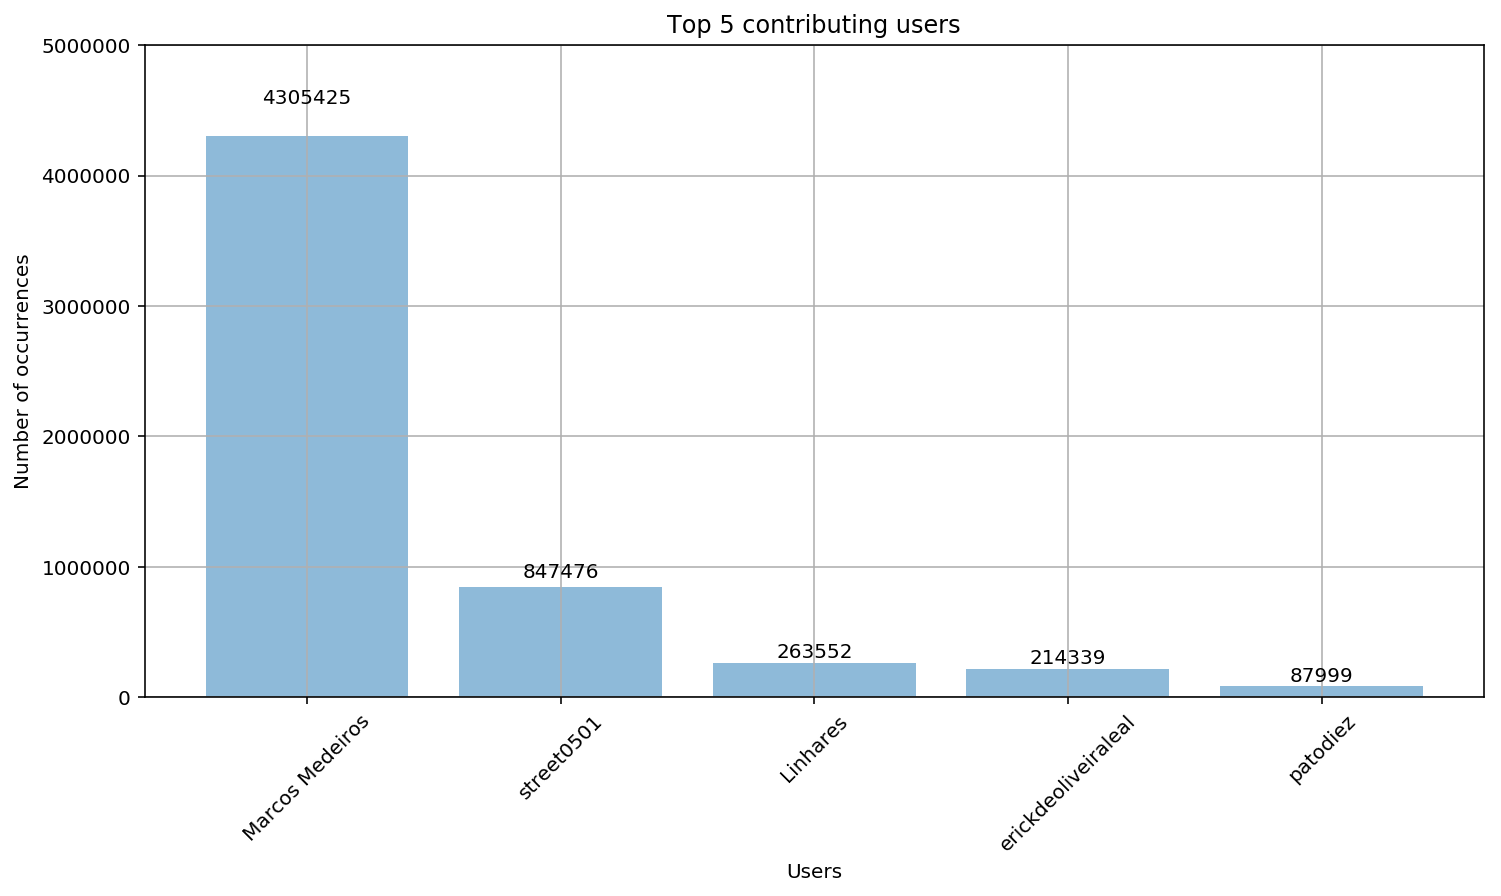

In [34]:
pipeline = [
    # Group by 'created.user' and sum all occurrences of it.
    {"$group":{"_id":"$created.user", "count":{"$sum":1}}},
    # Sorting by descending order.
    {"$sort":{"count":-1}},
    # Shows only first 5 documents.
    {"$limit":5}]

%time top5 = list(osm.aggregate(pipeline))
hlp.plot_top5(top5)

It can be noted that there is a big difference between the user `Marcos Medeiros` and the others. But the most curious thing is they map different regions. See the chart below. 

**Distribution of top 5 contributing users**

CPU times: user 1.08 ms, sys: 517 µs, total: 1.59 ms
Wall time: 74.5 ms


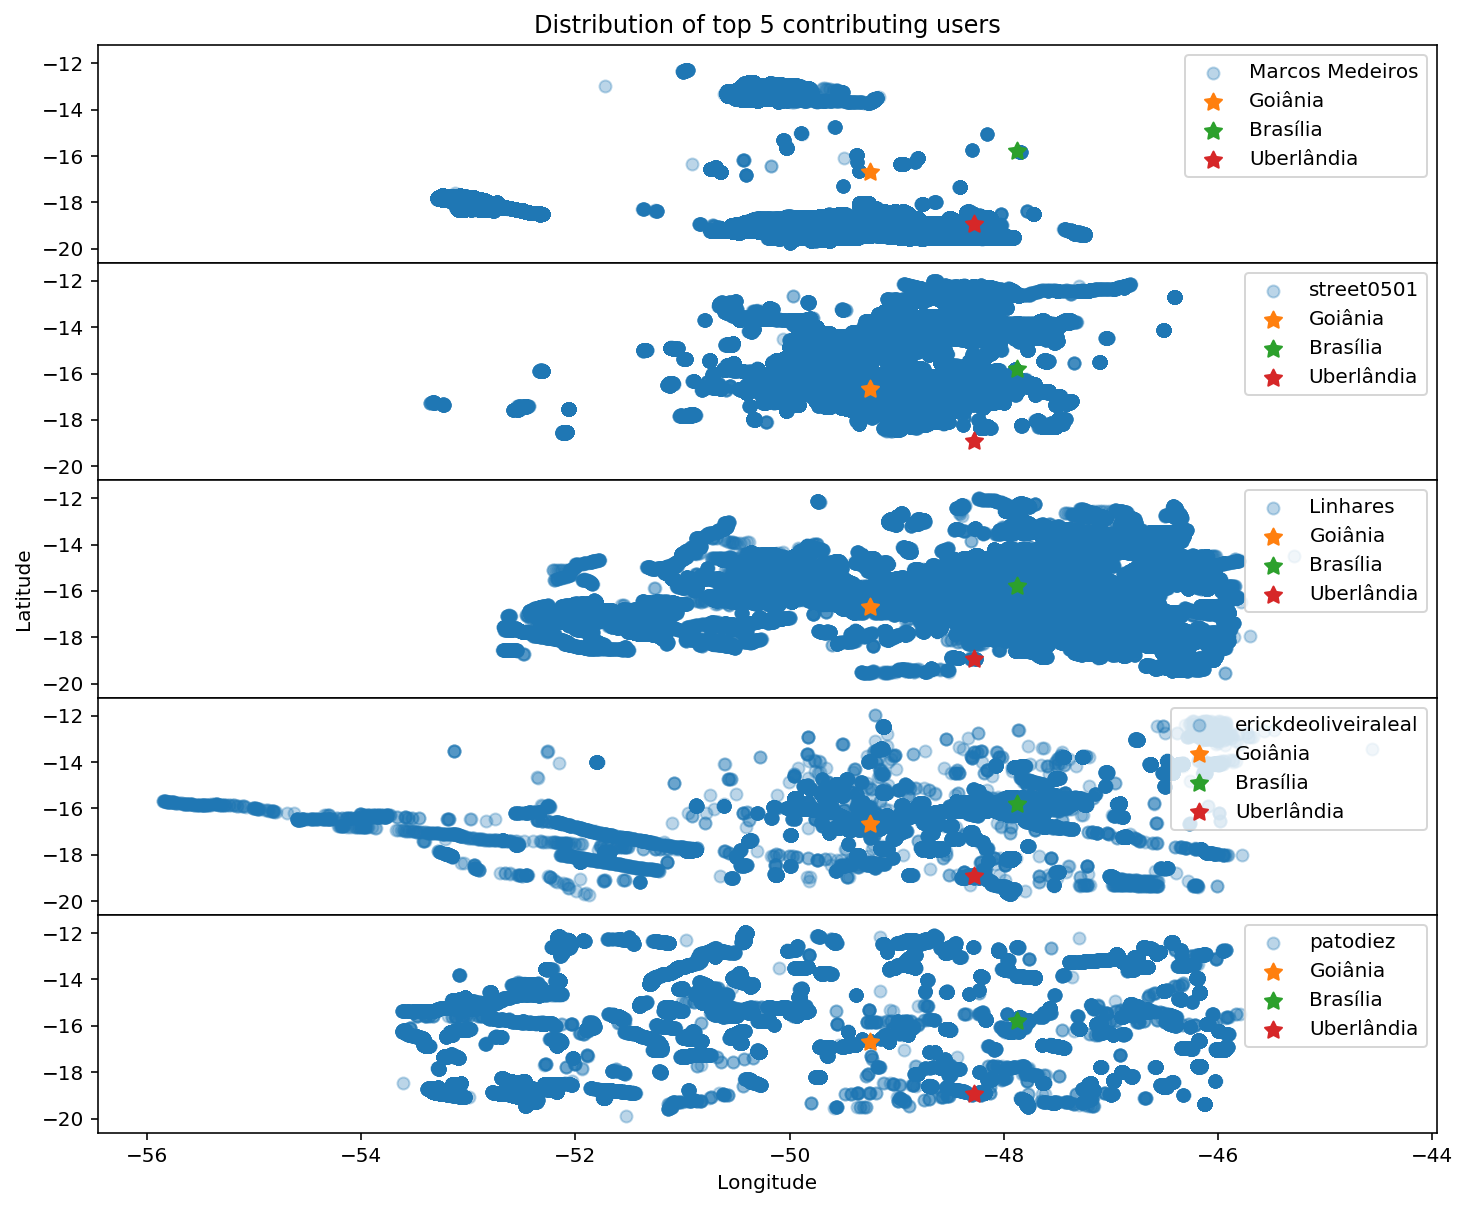

In [35]:
pipeline = [
    {   # Return only users in top5 list
        "$match":{
            "created.user": {"$in": [user['_id'] for user in top5]}
        }
    },
    {
        "$project":{
            "_id": 0,
            "user":"$created.user", 
            "lat": {"$arrayElemAt": ["$pos", 0]}, # Return element at 0 of 'pos' array
            "lon": {"$arrayElemAt": ["$pos", 1]}  # Return element at 1 of 'pos' array
        }
    }
]

%time loc_contrib_by_user = osm.aggregate(pipeline)
hlp.plot_dist_top5(loc_contrib_by_user)

`Marcos Medeiros` is the user who most inserted information in the studied region but different from the others he concentrated on three distant areas. The users `street0501` and `Linhares` densely mapped a large area. Already `erickdeoliveira` and `patodiez` have mapped a larger area but more sparsely than `erickdeoliveira` and `Linhares`.

## 7. Other Ideas About the Datasets

In OSM dataset, there are many problems related to non-standardization in the naming of things. For example, name cities. The same city is named with and without accentuation, with letters lowercase and uppercase.

In [43]:
%time cities = sorted(osm.distinct("address.city"))

print("")
print("Number of cities: {}\n".format(len(cities)))
print("Showing first 15 cities:")
cities[:15]

CPU times: user 1.67 ms, sys: 1.33 ms, total: 3 ms
Wall time: 3.2 s

Number of cities: 166

Showing first 15 cities:


[u'AN\xc1POLIS',
 u'Aguas Claras',
 u'Aguas lindas',
 u'Alex\xe2nia',
 u'Alo\xe2ndia',
 u'Alto Para\xedso de Goi\xe1s',
 u'Anapolis',
 u'Anhanguera',
 u'An\xe1polis',
 u'An\xe1polis - GO',
 u'An\xe1polis - Go',
 u'Aparecida de Goi\xe2nia',
 u'Araguainha',
 u'Araguari',
 u'Arapor\xe2']

Here, `Anápolis` city has 5 representations:

- `'AN\xc1POLIS'      => 'ANÁPOLIS'`
- `'Anapolis'`
- `'An\xe1polis'      => 'Anápolis'`
- `'An\xe1polis - GO' => 'Anápolis - GO'`
- `'An\xe1polis - Go' => 'Anápolis - Go'`

To help solve this kind of problem I believe techniques of [Record Linkage](https://en.wikipedia.org/wiki/Record_linkage) and [Entity Linkage](https://en.wikipedia.org/wiki/Entity_linking) migth be used in background during search indexes construction and in foreground during map editing. These techniques migth use natural language processing and machine learning (naive bayes algorithm and neural networks) to finding records in a dataset that refer to the same entity performing deduplication and disambiguation. 

Based on indexes created in background batch processing, the user, during map editing, migth be advised about "correct" sentence as "Did you mean" of Google Search does. 

> ![did you mean](./images/did_you_mean.png "did you mean")

Users with a role of curator in a specific region migth audit and correct possible false positives which may occur with [Record Linkage](https://en.wikipedia.org/wiki/Record_linkage) and [Entity Linkage](https://en.wikipedia.org/wiki/Entity_linking). Gamification techniques migth be used to elect curator users.

To help solve semantic problems in tag keys as I show in [4.1.1 Semantic Problems](#4.1.1-Semantic-Problems) I think that [Controlled Vocabulary](https://en.wikipedia.org/wiki/Controlled_vocabulary) might be useful together with [Ontology](https://en.wikipedia.org/wiki/Ontology_(information_science)). From such an ontology could be derived a scheme for validating the contents of map editing and an OSM XML dataset. A starting point for the creation of the mapping/geolocation domain ontology may be the [Taginfo](https://taginfo.openstreetmap.org/) site which already ranks the tags by use. The goal is to decrease or even eliminate the possibility of creating semantically equal key keys with different syntax. Perhaps to head it has to exist before a consortium such as the [W3C](https://www.w3.org/) which may not be a short-term solution.

To help solve syntatic problems in tag keys as I show in [4.1.2 Syntatic Problems](#4.1.2-Syntatic-Problems) I think that syntactic level of acceptance like password strength meter (see picture below) could be used. Only `great_key_name`
`good_key_name` and `regular_key_name` could be accept on tag creation.
 
> ![password strength meter](./images/password_strength_meter.jpg "password strength meter")

> Reference: http://ui-patterns.com/patterns/PasswordStrengthMeter

Summing up, try to prevent problems at the time the data enters the system supported by the knowledge acquired in the processing of data already contained in the database.